In [1]:
from models import NetworkedRENs, REN, RNNModel
import numpy as np
import matplotlib.pyplot as plt
import scipy
import os

os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
from os.path import dirname, join as pjoin
import torch
from torch import nn

In [2]:
dtype = torch.float
device = torch.device("cpu")

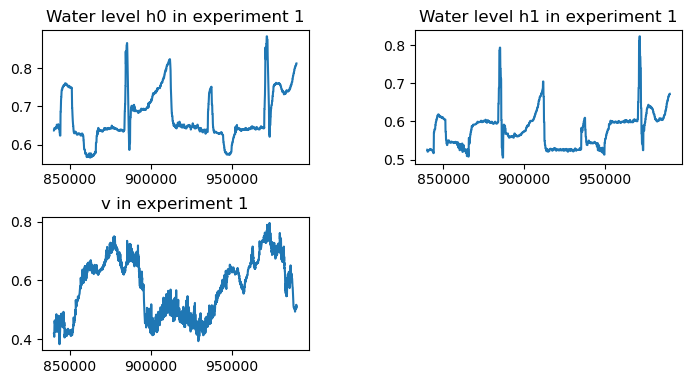

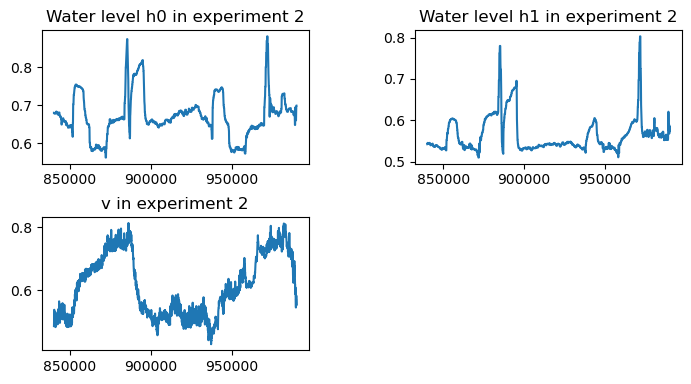

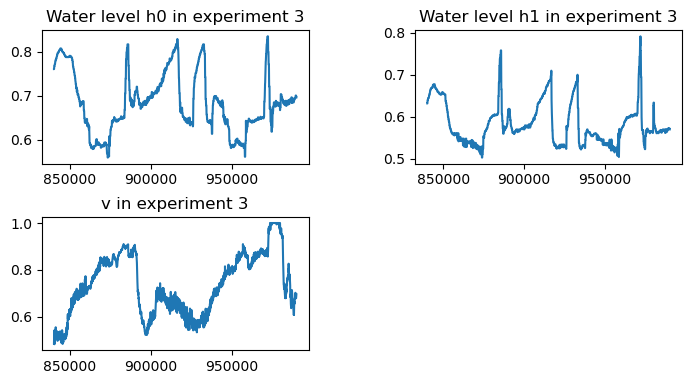

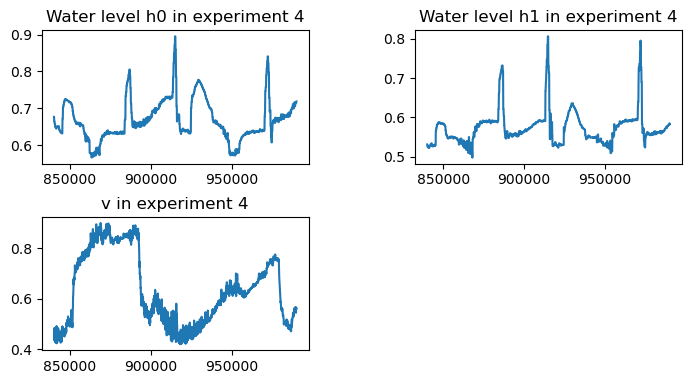

In [3]:
# Import Data
folderpath = os.getcwd()
filepath = pjoin(folderpath, 'input_3.mat')#'dataset_sysID_3tanks.mat')
data_in = scipy.io.loadmat(filepath)
filepath = pjoin(folderpath, 'output_Q_3.mat')
data_out = scipy.io.loadmat(filepath)
filepath = pjoin(folderpath, 'subsystems.mat')
data_sub = scipy.io.loadmat(filepath)

filepath = pjoin(folderpath, 'denormalize.mat')
data_max = scipy.io.loadmat(filepath)

# Extract data from dictionary
maxTrit, maxTdel = data_max['maxTrit'], data_max['maxTman']
Toutass_t, Toutass_v, Toutchill_t, Toutchill_v = data_sub['Toutass_train'], data_sub['Toutass_val'], data_sub['Toutchillers_train'], data_sub['Toutchillers_val']
dExp, yExp, dExp_val, yExp_val, time__, buildtot, buildtot_val = data_in['dExp'], data_out['yExp'], \
    data_in['dExp_val'], data_out['yExp_val'], data_in['time__'], data_out['buildtotnorm'], data_out['buildtotnorm_val']
nExp = yExp.size

t = time__

t_end = t.size

#initialize the model

ny = np.shape(yExp[0,-1])[1]
nd = np.shape(dExp[0,-1])[1]

#t = np.arange(0, np.size(dExp[0, 0], 1) * Ts-Ts, Ts)
#t_end = yExp[0, 0].shape[1] - 1

for exp in range(nExp):
    y_exp = yExp[0,exp]
    d_exp = dExp[0,exp]
    plt.figure(figsize=(4 * 2, 4))
    for out in range(ny):
        plt.subplot(2, 2, out+1)
        plt.plot(t[14000:16500], y_exp[14000:16500,out])
        plt.title(r"Water level h%i "%out + r"in experiment %i"%(exp+1))
    plt.subplot(2, 2, ny+1)
    plt.plot(t[14000:16500], d_exp[14000:16500,1])
    plt.title(r"v in experiment %i"%(exp+1))
    # set the spacing between subplots
    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.4)
plt.show()

In [4]:
# TRAIN OF NETWORKED RENs
epochs = 200
t_end = 2500

torch.manual_seed(2)
N = 3 # Number of interconnected systems

n = torch.tensor([2, 2, 2])  # input dimensions
p = torch.tensor([1, 1, 1])  # output dimensions

n_xi = np.array([5, 5, 5]) # nel paper n1, numero di stati
l = np.array([5, 5, 5])  # nel paper q, dimension of the square matrix D11 -- number of _non-linear layers_ of the RE

alpha = 0.6
beta = 0.4

Muy = torch.cat((torch.tensor([[0, alpha, beta], [1, 0, 0], [1, 0, 0]]), torch.zeros(3,3)), dim=0)
Muy = Muy.float()

Mud = torch.cat((torch.zeros(3,3), torch.eye(3)), dim=0)
Mey = torch.tensor([[0, alpha, beta], [1, 0, 0]])

# Define the system
RENsys = NetworkedRENs(N, Muy, Mud, Mey, n, p, n_xi, l)

# Define Loss function
MSE = nn.MSELoss()

# Define Optimization method
learning_rate = 1.0e-1
optimizer = torch.optim.Adam(RENsys.parameters(), lr=learning_rate)
optimizer.zero_grad()

LOSS = np.zeros(epochs)
loss = 0

for epoch in range(epochs):
    if epoch == epochs - epochs / 2:
        learning_rate = 1.0e-2
        optimizer = torch.optim.Adam(RENsys.parameters(), lr=learning_rate)
    if epoch == epochs - epochs / 6:
        learning_rate = 1.0e-3
        optimizer = torch.optim.Adam(RENsys.parameters(), lr=learning_rate)
    optimizer.zero_grad()
    loss = 0
    for exp in range(nExp - 1):
        xi = []
        y = torch.cat((torch.from_numpy(yExp[0, exp][14000:16500,0]).float().to(device).unsqueeze(1),
                       torch.from_numpy(Toutass_t[exp*30240 +14000:exp*30240 + 16500]).float().to(device),
                       torch.from_numpy(Toutchill_t[exp*30240 +14000:exp*30240 + 16500]).float().to(device)), dim=1)
        y = y.T
        yRENm = torch.randn(3,t_end , device=device, dtype=dtype)
        yRENm[0,:] = y[0,:]
        for j in range(N):
            xi.append(torch.randn(RENsys.r[j].n, device=device, dtype=dtype))
        d = torch.cat((torch.from_numpy(buildtot[exp*30240 +14000:exp*30240 + 16500]).float().to(device),
                       torch.from_numpy(dExp[0, exp][14000:16500,-1]).float().to(device).unsqueeze(1),
                       torch.from_numpy(dExp[0, exp][14000:16500,-2]).float().to(device).unsqueeze(1)), dim=1)
        d = d.T
        xi = torch.cat(xi)
        for t in range(1, t_end):
            yRENm[:, t], xi = RENsys(t, d[:, t - 1], xi)

        loss = loss + MSE(yRENm[:, 0:yRENm.size(1)], y[:, 0:t_end + 1])
        # ignorare da loss effetto condizione iniziale

    loss = loss / nExp
    loss.backward()
    # loss.backward(retain_graph=True)

    optimizer.step()

    print(f"Epoch: {epoch + 1} \t||\t Loss: {loss}")
    for net in range(N):
        print(f"L2 gain REN%i"%net+":%.1f"%RENsys.r[net].gamma)
    LOSS[epoch] = loss
    
    # Save the model parameters at the end of the epoch
    torch.save(RENsys.state_dict(), f'RENsys_epoch_{epoch+1}.pth')
    
    # Or save a checkpoint with optimizer and other details
    torch.save({
        'epoch': epoch,
        'model_state_dict': RENsys.state_dict(),
        'loss': loss,
    }, f'checkpoint_epoch_{epoch+1}.pth')




KeyboardInterrupt: 

In [ ]:
import torch

# Path to the last checkpoint
checkpoint_path = 'checkpoint_epoch_218.pth'

# Load the checkpoint
checkpoint = torch.load(checkpoint_path)

t_end = 2500
nExp = 1

torch.manual_seed(2)
N = 3 # Number of interconnected systems

n = torch.tensor([2, 2, 2])  # input dimensions
p = torch.tensor([1, 1, 1])  # output dimensions

n_xi = np.array([5, 5, 5]) # nel paper n1, numero di stati
l = np.array([5, 5, 5])  # nel paper q, dimension of the square matrix D11 -- number of _non-linear layers_ of the RE

alpha = 0.6
beta = 0.4

Muy = torch.cat((torch.tensor([[0, alpha, beta], [1, 0, 0], [1, 0, 0]]), torch.zeros(3,3)), dim=0)
Muy = Muy.float()

Mud = torch.cat((torch.zeros(3,3), torch.eye(3)), dim=0)
Mey = torch.tensor([[0, alpha, beta], [1, 0, 0]])

# Define the system
RENsys = NetworkedRENs(N, Muy, Mud, Mey, n, p, n_xi, l)

# Define Loss function
MSE = nn.MSELoss()
# Restore the model state
RENsys.load_state_dict(checkpoint['model_state_dict'])

# If needed, restore the optimizer state (for resuming training)
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Retrieve the last epoch and loss
last_epoch = checkpoint['epoch']
last_loss = checkpoint['loss']

print(f"Resuming from Epoch {last_epoch + 1} with Loss: {last_loss}")

# Ensure the model is in evaluation mode for validation
RENsys.eval()

# Perform validation
with torch.no_grad():
    validation_loss = 0
    for exp in range(nExp - 1):
        xi = []
        yval = torch.cat((torch.from_numpy(yExp_val[0, exp][14000:16500, 0]).float().to(device).unsqueeze(1),
                       torch.from_numpy(Toutass_v[exp * 30240 + 14000:exp * 30240 + 16500]).float().to(device),
                       torch.from_numpy(Toutchill_v[exp * 30240 + 14000:exp * 30240 + 16500]).float().to(device)), dim=1)
        yval = yval.T
        yRENm_val = torch.randn(3, t_end, device=device, dtype=torch.float)
        yRENm_val[0, :] = yval[0, :]
        
        for j in range(N):
            xi.append(torch.randn(RENsys.r[j].in_features, device=device, dtype=torch.float))
            
        dval = torch.cat((torch.from_numpy(buildtot_val[exp * 30240 + 14000:exp * 30240 + 16500]).float().to(device),
                       torch.from_numpy(dExp_val[0, exp][14000:16500, -1]).float().to(device).unsqueeze(1),
                       torch.from_numpy(dExp_val[0, exp][14000:16500, -2]).float().to(device).unsqueeze(1)), dim=1)
        dval = dval.T
        xi = torch.cat(xi)
        
        for t in range(1, t_end):
            yRENm_val[:, t], xi = RENsys(t, dval[:, t - 1], xi)

        validation_loss += MSE(yRENm_val[:, 0:yRENm_val.size(1)], yval[:, 0:t_end + 1])

    validation_loss = validation_loss / nExp
    print(f"Validation Loss: {validation_loss}")


Resuming from Epoch 218 with Loss: 0.00284033315256238
Validation Loss: 0.0


C:\Users\adela\AppData\Local\Temp\ipykernel_9676\2668403558.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


C:\Users\adela\AppData\Local\Temp\ipykernel_9676\2034064483.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


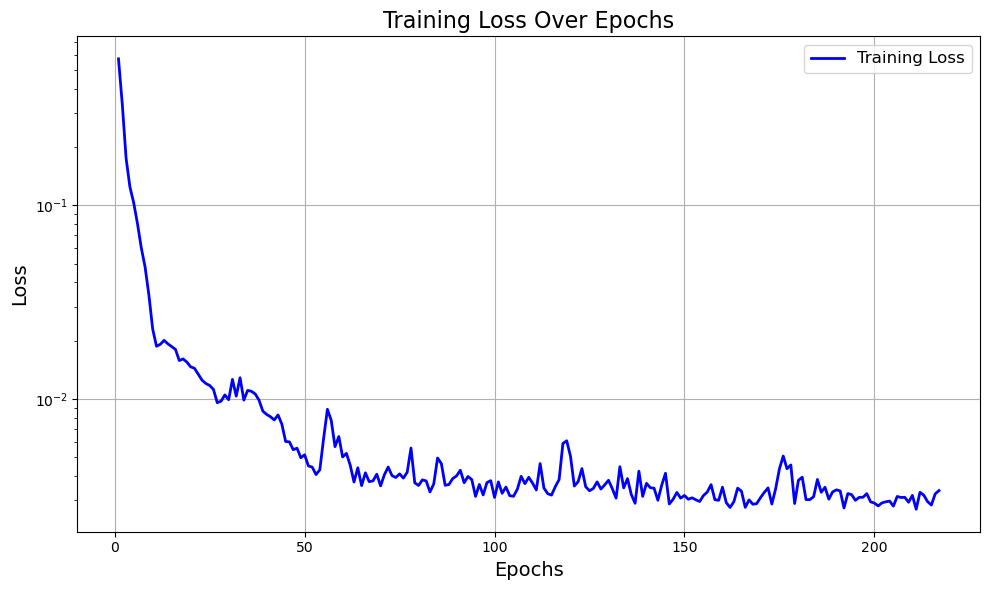

In [ ]:
import torch
import os
import matplotlib.pyplot as plt

# Directory containing the checkpoints
checkpoint_dir = './'  # Adjust if checkpoints are saved in a different directory

# Initialize an empty list to store loss values
LOSS = []

# Iterate over all checkpoint files
for epoch in range(1, 218):  
    checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch}.pth')
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        LOSS.append(checkpoint['loss'].item())  # Append the loss value
    else:
        print(f"Checkpoint for epoch {epoch} not found.")
        break

# Convert LOSS to a NumPy array for better handling (optional)
LOSS = np.array(LOSS)

# Plot the loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(LOSS) + 1), LOSS, label='Training Loss', color='blue', linewidth=2)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.yscale('log')
plt.title('Training Loss Over Epochs', fontsize=16)
plt.grid(True)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


In [ ]:
plt.figure(figsize=(4 * 2, 4))
plt.plot(LOSS)
plt.title("Loss function")
plt.show()


NameError: name 'LOSS' is not defined

<Figure size 800x400 with 0 Axes>

In [ ]:
# Validation
xi = []
y = torch.from_numpy(yExp[0, 0]).float().to(device)
y = y.T
yRENm = torch.zeros(3, t_end, device=device, dtype=dtype)
yRENm[0,:] = y[0,:]
for j in range(N):
    xi.append(torch.randn(RENsys.r[j].n, device=device, dtype=dtype))
dtrain = torch.from_numpy(dExp[0, 0]).float().to(device)
xi = torch.cat(xi)
for t in range(1, t_end):
    yRENm[:, t], xi = RENsys(t, dtrain[:, t - 1], xi)


#t_end = yExp_val[0, 0].shape[0] - 1
t_end = 2500
xiVal =[]
yval = torch.from_numpy(yExp_val[0, 0]).float().to(device)
yval = yval.squeeze().T
yRENm_val = torch.zeros(3, t_end + 1, device=device, dtype=dtype)
yRENm_val[:,0] = yval[:,0]
for j in range(N):
    xiVal.append(torch.randn(RENsys.r[j].n, device=device, dtype=dtype))
dval = torch.from_numpy(dExp_val[0, 0]).float().to(device).T
xiVal = torch.cat(xiVal)
loss_val = 0
for t in range(1, t_end):
    yRENm_val[:, t], xiVal = RENsys(t, dval[:, t - 1], xiVal)
loss_val = loss_val + MSE(yRENm_val[:, 0:yRENm_val.size(1)], yval[:, 0:t_end + 1])

plt.figure(figsize=(4 * 2, 4))
for out in range(ny):
    plt.subplot(1, ny, out+1)
    plt.plot(yRENm[out, 0:t_end].detach().numpy(), label='networked REN train')
    plt.plot(y[out, 0:t_end].detach().numpy(), label='y train')
    plt.title(r"h%i"%out + r"in train")  
plt.show()

plt.figure(figsize=(4 * 2, 4))
for out in range(ny):
    plt.subplot(1, ny, out+1)
    plt.plot(yRENm_val[out, 0:t_end].detach().numpy(), label='networked REN val')
    plt.plot(yval[out, 0:t_end].detach().numpy(), label='y val')
    plt.title(r"h%i\n"%out + r"in val")  
plt.show()

pytorch_total_params_3RENs = sum(p.numel() for p in RENsys.parameters() if p.requires_grad)

print(f"param networked RENs: {pytorch_total_params_3RENs}")
#print(f"param single REN: {pytorch_total_params_singleREN}")
#print(f"param single REN: {pytorch_total_params_singleRNN}")


print(f"Loss Validation networked RENs: {loss_val}")

RuntimeError: The expanded size of the tensor (2500) must match the existing size (30240) at non-singleton dimension 0.  Target sizes: [2500].  Tensor sizes: [30240]

(2500, 1)
(2500,)
(2500,)
torch.Size([2500, 3])


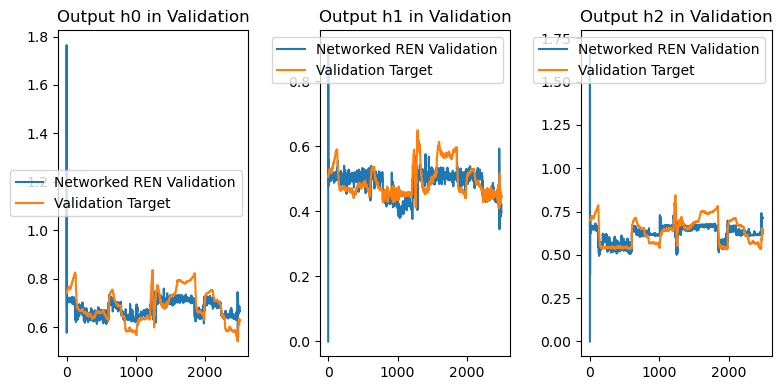

Validation Loss: 0.0027659740298986435
Total trainable parameters in REN system: 860


In [ ]:
# Validation for Networked RENs
torch.manual_seed(2)  # Ensure reproducibility

# Validation parameters
t_end = 2500  # Same as training sequence length
xi = []


# Prepare validation outputs
yval = torch.cat((
    torch.from_numpy(yExp_val[0, 0][2000:4500, 0]).float().to(device).unsqueeze(1),
    torch.from_numpy(Toutass_v[2000:4500]).float().to(device),#.unsqueeze(1),
    torch.from_numpy(Toutchill_v[2000:4500]).float().to(device)#.unsqueeze(1)
), dim=1).T

yRENm_val = torch.zeros(3, t_end, device=device, dtype=dtype)
yRENm_val[0, :] = yval[0, :]  # Initialize with first channel of validation output

# Initialize states for REN validation
for j in range(N):
    xi.append(torch.randn(RENsys.r[j].n, device=device, dtype=dtype))
xi = torch.cat(xi)

print(buildtot_val[2000:4500].shape)
print(dExp_val[0, 0][2000:4500, -1].shape)
print(dExp_val[0, 0][2000:4500, -2].shape)
# Prepare validation disturbances
dval = torch.cat((
    torch.from_numpy(buildtot_val[2000:4500]).float().to(device),#.unsqueeze(0),
    torch.from_numpy(dExp_val[0, 0][2000:4500, -1]).float().to(device).unsqueeze(1),
    torch.from_numpy(dExp_val[0, 0][2000:4500, -2]).float().to(device).unsqueeze(1)
), dim=1)

print(dval.size())
dval = dval.T

# Validation simulation loop
loss_val = 0
for t in range(1, t_end):
    yRENm_val[:, t], xi = RENsys(t, dval[:, t - 1], xi)

# Compute validation loss
loss_val = MSE(yRENm_val[:, :t_end], yval[:, :t_end])

# Plot Training Outputs
plt.figure(figsize=(8, 4))
for out in range(3):  # Assuming 3 outputs
    plt.subplot(1, 3, out + 1)
    plt.plot(yRENm_val[out, :].detach().cpu().numpy(), label="Networked REN Validation")
    plt.plot(yval[out, :].detach().cpu().numpy(), label="Validation Target")
    plt.title(f"Output h{out} in Validation")
    plt.legend()
plt.tight_layout()
plt.show()

# Total Parameters in Networked RENs
total_params = sum(p.numel() for p in RENsys.parameters() if p.requires_grad)

# Print Validation Results
print(f"Validation Loss: {loss_val.item()}")
print(f"Total trainable parameters in REN system: {total_params}")


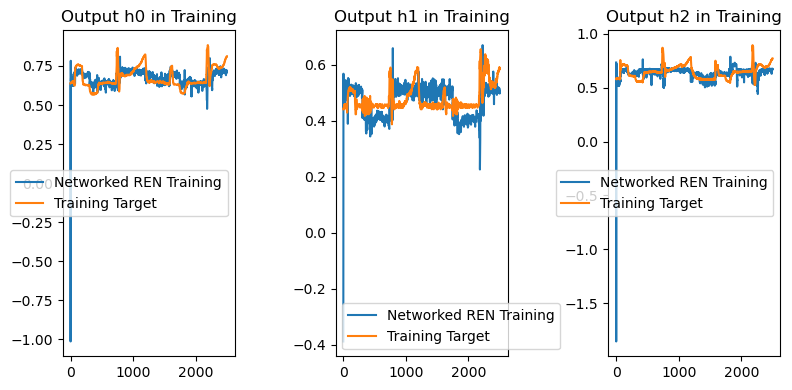

In [ ]:
# Plot Training Outputs
xi = []
y = torch.cat((torch.from_numpy(yExp[0, exp][14000:16500,0]).float().to(device).unsqueeze(1),
                       torch.from_numpy(Toutass_t[exp*30240 +14000:exp*30240 + 16500]).float().to(device),
                       torch.from_numpy(Toutchill_t[exp*30240 +14000:exp*30240 + 16500]).float().to(device)), dim=1)
y = y.T
yRENm = torch.randn(3,t_end , device=device, dtype=dtype)
yRENm[0,:] = y[0,:]
for j in range(N):
    xi.append(torch.randn(RENsys.r[j].n, device=device, dtype=dtype))
d = torch.cat((torch.from_numpy(buildtot[0*30240 +14000:0*30240 + 16500]).float().to(device),
                torch.from_numpy(dExp[0, 0][14000:16500,-1]).float().to(device).unsqueeze(1),
                torch.from_numpy(dExp[0, 0][14000:16500,-2]).float().to(device).unsqueeze(1)), dim=1)
d = d.T
xi = torch.cat(xi)
for t in range(1, t_end):
    yRENm[:, t], xi = RENsys(t, d[:, t - 1], xi)
            
plt.figure(figsize=(8, 4))
for out in range(3):  # Assuming 3 outputs
    plt.subplot(1, 3, out + 1)
    plt.plot(yRENm[out,:].detach().cpu().numpy(), label="Networked REN Training")
    plt.plot(y[out, :].detach().cpu().numpy(), label="Training Target")
    plt.title(f"Output h{out} in Training")
    plt.legend()
plt.tight_layout()
plt.show()